In [2]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Siamese Recurrent Architectures for Leaning Sentence Similarity

(Mueller and Thyagarajan, 2016)

[![Man_LSTM](https://www.researchgate.net/profile/Zainab_Imtiaz2/publication/338786070/figure/fig1/AS:856942448742404@1581322409882/Siamese-Manhattan-LSTM-netowrk-with-zero-padding-for-max-sequence-length-20.png)](https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FSiamese-Manhattan-LSTM-netowrk-with-zero-padding-for-max-sequence-length-20_fig1_338786070&psig=AOvVaw3SZ6t8pqGblLlb5BAdF6zD&ust=1594765945082000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCLiAx6Gky-oCFQAAAAAdAAAAABAD)

## Project Folder Structure
/data: Folder for all data

## Section 0: Setup 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import torchtext
from torchtext import data
import spacy
import nltk
import matplotlib.pyplot as plt


torch.manual_seed(1)
torch.backends.cuda.deterministic = True

## Section I: Exploratory Data Analysis

In [4]:
## Read in dataset, select "pair_ID" as index col
sickdata = pd.read_csv("/content/drive/My Drive/Colab Notebooks/final project/data/SICK.csv", index_col="pair_ID", sep="\t")

## drop N/A in the columns
sickdata.dropna(subset=['sentence_A'], inplace=True)
sickdata.dropna(subset=['sentence_B'], inplace=True)
sickdata.head(5)

,sentence_A,sentence_B,entailment_label,relatedness_score,entailment_AB,entailment_BA,sentence_A_original,sentence_B_original,sentence_A_dataset,sentence_B_dataset,SemEval_set
pair_ID,,,,,,,,,,,
1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,NEUTRAL,4.5,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...","A group of children playing in a yard, a man i...",FLICKR,FLICKR,TRAIN
2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.2,A_contradicts_B,B_neutral_A,"A group of children playing in a yard, a man i...","A group of children playing in a yard, a man i...",FLICKR,FLICKR,TRAIN
3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,ENTAILMENT,4.7,A_entails_B,B_entails_A,"The children are playing outdoors, while a man...","The children are playing outdoors, while a man...",FLICKR,FLICKR,TRAIN
4,The young boys are playing outdoors and the ma...,There is no boy playing outdoors and there is ...,CONTRADICTION,3.6,A_contradicts_B,B_contradicts_A,"The children are playing outdoors, while a man...","The children are playing outdoors, while a man...",FLICKR,FLICKR,TRIAL
5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,NEUTRAL,3.4,A_neutral_B,B_neutral_A,"A group of children playing in a yard, a man i...","The children are playing outdoors, while a man...",FLICKR,FLICKR,TRAIN


In [5]:
# the header of dataset
list(sickdata.columns.values)

['sentence_A',
 'sentence_B',
 'entailment_label',
 'relatedness_score',
 'entailment_AB',
 'entailment_BA',
 'sentence_A_original',
 'sentence_B_original',
 'sentence_A_dataset',
 'sentence_B_dataset',
 'SemEval_set']

### Retrieve train, validate, test data

In [6]:
train_data = sickdata[sickdata.SemEval_set == 'TRAIN']
print(f'No. train: {len(train_data)}')
val_data = sickdata[sickdata.SemEval_set == 'TRIAL']
print(f'No. validation: {len(val_data)}')
test_data = sickdata[sickdata.SemEval_set == 'TEST']
print(f'No. validation: {len(test_data)}')

No. train: 4439
No. validation: 495
No. validation: 4906


In [7]:
# save each set into separate csv files, easier for TorchText to generate batches
DATA_FOLDER = "/content/drive/My Drive/Colab Notebooks/final project/data"
train_data.to_csv(DATA_FOLDER+ "/SICK_train.csv")
val_data.to_csv(DATA_FOLDER+"/SICK_val.csv")
test_data.to_csv(DATA_FOLDER+"/SICK_test.csv")

## Section II: Preprocessing




### Step 1: Define fields

These define how your data should be processed

In [8]:
TEXT1 = data.Field(sequential=True, tokenize="spacy", lower=True, include_lengths=True)
TEXT2 = data.Field(sequential=True, tokenize="spacy", lower=True, include_lengths=True)
SCORE = data.LabelField(dtype=torch.float, use_vocab=False)

### Step 2: Load Dataset

In [9]:
from torchtext.data import TabularDataset

# Define fields
# Pass in None for the columns we don't use
datafields = [("pair_ID", None), ("sentence_A", TEXT1), ("sentence_B", TEXT2), ("entailment_label", None), ("relatedness_score", SCORE), 
                  ("entailment_AB", None), ("entailment_BA", None), ("sentence_A_original", None), ("sentence_B_original", None), 
                  ("sentence_A_dataset", None), ("sentence_B_dataset", None), ("SemEval_set", None)]

# skip_header: if csv has a header, ensure to pass this so it doesn't get processed as data
train, val, test = data.TabularDataset.splits(
    path = DATA_FOLDER,
    train="SICK_train.csv",
    validation="SICK_val.csv", 
    test = "SICK_test.csv",
    format = "csv",
    fields=datafields,
    skip_header = True
)

Show examples in a batch

In [10]:
print(train[0]) # get an Example object, it bundles the attributes of a single data point together
print(train[0].__dict__.keys())
print(train[0].sentence_A) # tokenized sentence, but not be converted to integer yet
print(train[0].sentence_B) # tokenized sentence, but not be converted to integer yet
print(train[0].relatedness_score) # tokenized sentence, but not be converted to integer yet

dict_keys(['sentence_A', 'sentence_B', 'relatedness_score'])
['a', 'group', 'of', 'kids', 'is', 'playing', 'in', 'a', 'yard', 'and', 'an', 'old', 'man', 'is', 'standing', 'in', 'the', 'background']
['a', 'group', 'of', 'boys', 'in', 'a', 'yard', 'is', 'playing', 'and', 'a', 'man', 'is', 'standing', 'in', 'the', 'background']
4.5


### Step 3: Build vocab

In [11]:
from torchtext import vocab
# build vocabulary on training set, limited to MAX_VOCAB_SIZE, and import glove as pretrained word embedding
MAX_VOCAB_SIZE = 25_000
# vec = vocab.Vectors('glove.42B.300d.txt', cache="./")
TEXT1.build_vocab(train, max_size=MAX_VOCAB_SIZE)
TEXT2.build_vocab(train, max_size=MAX_VOCAB_SIZE)
print(f"Unique tokens in Sentence 1 vocabulary: {len(TEXT1.vocab)}")
print(f"Unique tokens in Sentence 2 vocabulary: {len(TEXT2.vocab)}")
# print(TEXT.vocab.stoi)

Unique tokens in Sentence 1 vocabulary: 1957
Unique tokens in Sentence 2 vocabulary: 1909


In [12]:
# view the most common words in the vocabulary and their frequencies
print(TEXT1.vocab.freqs.most_common(20))

[('a', 6220), ('is', 4079), ('the', 2351), ('man', 1271), ('in', 1144), ('and', 1018), ('are', 861), ('on', 857), ('woman', 641), ('of', 593), ('dog', 551), ('playing', 537), ('with', 500), ('two', 354), ('no', 275), ('by', 272), ('an', 255), ('there', 255), ('person', 247), ('boy', 247)]


In [13]:
# view the vocabulary directly using the stoi (string to integer)
print(TEXT1.vocab.itos[:10])

['<unk>', '<pad>', 'a', 'is', 'the', 'man', 'in', 'and', 'are', 'on']


### Step 4: Build iterator that return batches of examples

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Generated iterator will be automatically loaded to device
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, val, test), 
    batch_size = 64, 
    sort_key = lambda x: x.sentence_A, 
    device = device
)

Device: cuda


In [15]:
for batch in train_iterator:
  text_a, text_length = batch.sentence_A
  # print(text_a.shape)

## Section III: Build Model

In [35]:
class Manhattan_LSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional):
    super(Manhattan_LSTM, self).__init__()
    
    # transform our sparse one-hot vector into dense embedding vector, it's simply a FC layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    # self.dropout = nn.Dropout(dropout)

    self.lstm_a = nn.LSTM(embedding_dim, 
                          hidden_dim,
                          num_layers=n_layers, 
                          bidirectional=bidirectional
                          ) 
    # self.lstm_b = nn.LSTM(embedding_dim, 
    #                       hidden_dim, 
    #                       num_layers=n_layers, 
    #                       bidirectional=bidirectional
    #                       ) 
        
  def exp_neg_manhattan_dist(self, x1, x2):
        """
        Function for the similarity estimate of the LSTMs outputs 
        g(h_a, h_b) = exp(-||h_a-h_b||_1)

        output: 
          shape: [batch size, 1]
        """
        # print(f"exp {torch.exp(-torch.sum(torch.abs(x1 - x2), dim=1))}")

        return torch.exp(-torch.sum(torch.abs(x1 - x2), dim=1))

  def forward(self, text_a, text_b, text_lengths):
        '''
        It is called when we feed exampples into our model

        input
            text_a, text_b
        output:
            score: predicted similarity score b/t 1, 5
        '''
        # text: [sent len for that batch,  batch size]
        # embedded: [sent len, batch size, emb dim]
        embedded_1 = self.embedding(text_a)
        embedded_2 = self.embedding(text_b) 

        # output: [seq length, batch, num_directions*hidden_size]
        # hidden state: [n_layers, batch size, hidden dim]
        # cell state: [n_layers, batch size, hidden dim]
        outputs_1, (hidden_1, cell_1) = self.lstm_a(embedded_1)
        outputs_2, (hidden_2, cell_2) = self.lstm_a(embedded_2)

        batch_size = text_a.shape[1]
        
        # first convert to shape [batch size, hidden dim, 2], then to shape [batch size, hidden dim * 2]
        # compute Manhattan distance
        similarity_scores = self.exp_neg_manhattan_dist(hidden_1.permute(1, 2, 0).reshape(batch_size, -1),
                                                                 hidden_2.permute(1, 2, 0).reshape(batch_size, -1))
        
        # Multiply by 5, since exp_neg_manhattan_dist in [0,1], and similarity_score in [1, 5]
        return similarity_scores*5.0

In [36]:
input_dim = len(TEXT1.vocab)
embedding_dim = 300
hidden_dim = 50
output_dim = 1
n_layers = 1
bidirectional = False

# create MaLSTM model
model = Manhattan_LSTM(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional)
model.to(device)

Manhattan_LSTM(
  (embedding): Embedding(1957, 300)
  (lstm_a): LSTM(300, 50)
)

In [37]:
def count_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_params(model)}: trainable parameters')

The model has 657500: trainable parameters


In [38]:
def train(model, iterator, optimizer, criterion, threshold):
  epoch_loss = 0
  
  model.train()

  for batch in iterator: 
    # clear old gradients
    optimizer.zero_grad()
    text_a, text_lengths = batch.sentence_A
    text_b, text_lengths = batch.sentence_B
    pred = model(text_a, text_b, text_lengths)
    loss = criterion(pred, batch.relatedness_score)
    
    # print(f"acc: {acc}")
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item() # to get a Python num from a tensor of a single value
    
  return epoch_loss/len(iterator)

In [39]:
def inference(model, iterator, criterion, threshold):
  epoch_loss = 0

  model.eval()

  with torch.no_grad():
    for batch in iterator: 
      text_a, text_lengths = batch.sentence_A
      text_b, text_lengths = batch.sentence_B
      pred = model(text_a, text_b, text_lengths)
      loss = criterion(pred, batch.relatedness_score)
      epoch_loss += loss.item()
      
  return epoch_loss/len(iterator)

In [40]:
import time

def epoch_time(start_time, end_time):
  """
  Helper function to compute time
  """
  elapsed_time = end_time - start_time
  return elapsed_time

In [41]:
import torch.optim as optim


N_EPOCHS = 50
best_valid_loss = float('inf')
train_loss_lst = []
validation_loss_lst = []
lr = 0.01
threshold = 0.3

optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = 0.01)
criterion = nn.MSELoss()
criterion = criterion.to(device)


for epoch in range(N_EPOCHS):
  start_time = time.time()
  train_loss = train(model, train_iterator, optimizer, criterion, threshold)
  train_loss_lst.append(train_loss)

  valid_loss = inference(model, valid_iterator, criterion, threshold)
  validation_loss_lst.append(valid_loss)
 
  end_time = time.time()

  elapsed_time = epoch_time(start_time, end_time)
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best_ManLSTM.pt')

  print(f'Epoch: {epoch+1:02} | Epoch Time: {elapsed_time} sec')
  print(f'\tTrain Loss: {train_loss: .3f} | Valid Loss Acc: {valid_loss: .3f} ')

Epoch: 01 | Epoch Time: 0.411865234375 sec
	Train Loss:  1.944 | Valid Loss Acc:  1.728 
Epoch: 02 | Epoch Time: 0.41300272941589355 sec
	Train Loss:  1.356 | Valid Loss Acc:  1.551 
Epoch: 03 | Epoch Time: 0.40836477279663086 sec
	Train Loss:  1.141 | Valid Loss Acc:  1.084 
Epoch: 04 | Epoch Time: 0.3835587501525879 sec
	Train Loss:  0.872 | Valid Loss Acc:  0.968 
Epoch: 05 | Epoch Time: 0.40233731269836426 sec
	Train Loss:  0.836 | Valid Loss Acc:  0.912 
Epoch: 06 | Epoch Time: 0.3825247287750244 sec
	Train Loss:  0.855 | Valid Loss Acc:  0.881 
Epoch: 07 | Epoch Time: 0.38497233390808105 sec
	Train Loss:  0.846 | Valid Loss Acc:  0.926 
Epoch: 08 | Epoch Time: 0.41097259521484375 sec
	Train Loss:  0.855 | Valid Loss Acc:  0.913 
Epoch: 09 | Epoch Time: 0.3791630268096924 sec
	Train Loss:  0.855 | Valid Loss Acc:  0.917 
Epoch: 10 | Epoch Time: 0.3897209167480469 sec
	Train Loss:  0.845 | Valid Loss Acc:  0.932 
Epoch: 11 | Epoch Time: 0.38112926483154297 sec
	Train Loss:  0.871 |

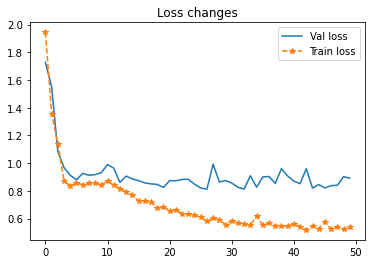

In [42]:
plt.plot(validation_loss_lst)
plt.plot(train_loss_lst, "*--")
plt.title("Loss changes")
plt.legend(['Val loss', "Train loss"])

In [44]:
model.load_state_dict(torch.load('best_ManLSTM.pt'))
test_loss= inference(model, test_iterator, criterion, threshold)
print(f"Test Loss: {test_loss:.3f}")

Test Loss: 0.851
